In [1]:
#!/usr/bin/env python3
"""
Visualization script for k-shot accuracy analysis from sst2_results.
Analyzes llama-3.1-8b-instruct across multiple seeds for SST2 sentiment analysis.
"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import glob
from collections import defaultdict
import os

# Set the style for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')

# Configure matplotlib for better aesthetics
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18

In [2]:
# Define the model and path
model_name = 'llama-3.1-8b-instruct'
results_folder = f'sst2_results/{model_name}/'

def load_sst2_data(results_folder):
    """
    Load data from sst2_results.
    Returns: data_dict[seed][k_shot] = accuracy
    """
    # Load all metadata JSON files
    metadata_files = glob.glob(os.path.join(results_folder, 'metadata_seed_*_k*.json'))
    
    # Organize data: data_dict[seed][k_shot] = accuracy
    data_dict = defaultdict(dict)
    all_seeds = set()
    all_k_shots = set()
    
    # Parse all JSON files
    for filepath in metadata_files:
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        seed = data['seed']
        k_shot = data['k_shot']
        accuracy = data['accuracy'] * 100  # Convert to percentage
        
        data_dict[seed][k_shot] = accuracy
        all_seeds.add(seed)
        all_k_shots.add(k_shot)
    
    return data_dict, sorted(all_seeds), sorted(all_k_shots)

# Load the data
print(f"Loading data from {results_folder}...")
data_dict, all_seeds, all_k_shots = load_sst2_data(results_folder)

print(f"Found {len(all_seeds)} seeds: {all_seeds}")
print(f"Found {len(all_k_shots)} k-shot values: {all_k_shots}")
print()

Loading data from sst2_results/llama-3.1-8b-instruct/...
Found 5 seeds: [42, 123, 999, 3407, 114514]
Found 9 k-shot values: [0, 1, 2, 3, 4, 8, 16, 32, 64]



In [3]:
# Organize data into matrix: shape (num_seeds, num_k_shots)
accuracy_matrix = []

for seed in all_seeds:
    seed_accuracies = []
    for k_shot in all_k_shots:
        acc = data_dict[seed].get(k_shot, np.nan)
        seed_accuracies.append(acc)
    accuracy_matrix.append(seed_accuracies)

accuracy_matrix = np.array(accuracy_matrix)

# Calculate mean and std across seeds (axis=0)
mean_accuracy = np.nanmean(accuracy_matrix, axis=0)
std_accuracy = np.nanstd(accuracy_matrix, axis=0)

# Count valid data points for each k-shot
valid_counts = np.sum(~np.isnan(accuracy_matrix), axis=0)

# Print statistics
print("Statistics:")
print("=" * 60)
for i, k in enumerate(all_k_shots):
    if not np.isnan(mean_accuracy[i]):
        print(f"K-shot {k}: Mean = {mean_accuracy[i]:.2f}%, Std = {std_accuracy[i]:.2f}%, n = {int(valid_counts[i])}")
    else:
        print(f"K-shot {k}: No data available")
print()

Statistics:
K-shot 0: Mean = 82.47%, Std = 0.00%, n = 5
K-shot 1: Mean = 93.33%, Std = 0.55%, n = 5
K-shot 2: Mean = 93.93%, Std = 0.71%, n = 5
K-shot 3: Mean = 94.68%, Std = 0.61%, n = 5
K-shot 4: Mean = 95.03%, Std = 0.32%, n = 5
K-shot 8: Mean = 95.21%, Std = 0.41%, n = 5
K-shot 16: Mean = 95.19%, Std = 0.22%, n = 5
K-shot 32: Mean = 94.91%, Std = 0.52%, n = 5
K-shot 64: Mean = 94.94%, Std = 0.23%, n = 5



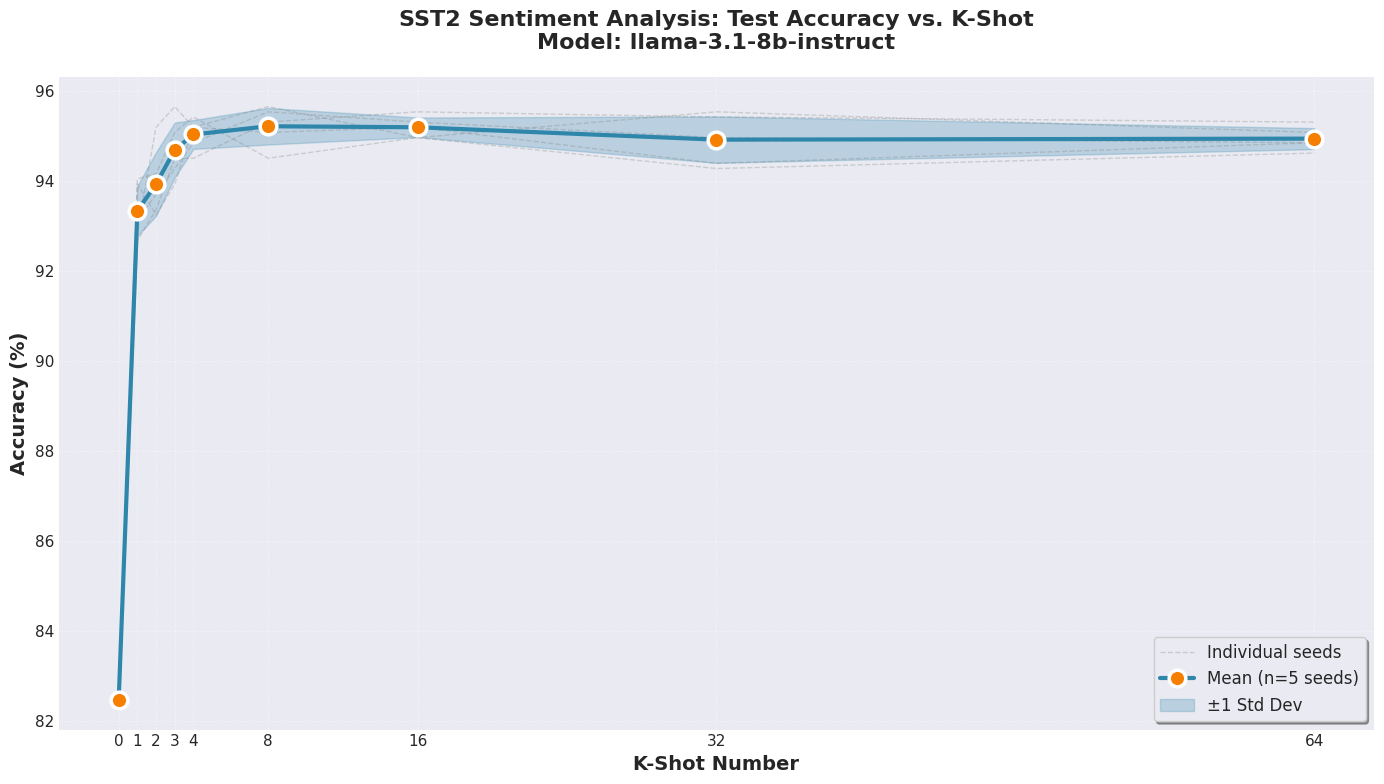

In [4]:
# Create the main plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot individual seeds as light lines
for seed_idx, seed in enumerate(all_seeds):
    ax.plot(all_k_shots, accuracy_matrix[seed_idx], 
            linestyle='--', linewidth=1, alpha=0.3, color='gray',
            label='Individual seeds' if seed_idx == 0 else '')

# Plot mean with markers
ax.plot(all_k_shots, mean_accuracy, marker='o', linewidth=3, markersize=12,
        color='#2E86AB', markerfacecolor='#F77F00', 
        markeredgewidth=2.5, markeredgecolor='white', 
        label=f"Mean (n={len(all_seeds)} seeds)", zorder=3)

# Add shaded region for ±1 standard deviation
ax.fill_between(all_k_shots, 
                mean_accuracy - std_accuracy, 
                mean_accuracy + std_accuracy,
                alpha=0.25, color='#2E86AB', 
                label='±1 Std Dev', zorder=1)

# Customize the plot
ax.set_xlabel('K-Shot Number', fontweight='bold', fontsize=14)
ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=14)
ax.set_title(f'SST2 Sentiment Analysis: Test Accuracy vs. K-Shot\nModel: {model_name}', 
             fontweight='bold', fontsize=16, pad=20)

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# Customize ticks
ax.set_xticks(all_k_shots)
ax.set_xticklabels([str(k) for k in all_k_shots])

# Set y-axis limits (optional - uncomment to fix range)
# ax.set_ylim(0, 100)

# Add legend
ax.legend(loc='best', frameon=True, shadow=True, fancybox=True)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [5]:
# Save the figure
output_path = f'sst2_kshot_accuracy_{model_name}.png'
fig.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Figure saved to: {output_path}")

# Save as PDF as well
output_path_pdf = f'sst2_kshot_accuracy_{model_name}.pdf'
fig.savefig(output_path_pdf, bbox_inches='tight', facecolor='white')
print(f"Figure saved to: {output_path_pdf}")

print("\n" + "="*60)
print("Visualization complete!")
print("="*60)

Figure saved to: sst2_kshot_accuracy_llama-3.1-8b-instruct.png
Figure saved to: sst2_kshot_accuracy_llama-3.1-8b-instruct.pdf

Visualization complete!


In [6]:
# Optional: Create a detailed table view
import pandas as pd

# Create a DataFrame for easier viewing
df_data = {'k_shot': all_k_shots}
for seed in all_seeds:
    df_data[f'seed_{seed}'] = [data_dict[seed].get(k, np.nan) for k in all_k_shots]

df_data['mean'] = mean_accuracy
df_data['std'] = std_accuracy

df = pd.DataFrame(df_data)
print("\nDetailed accuracy table:")
print(df.to_string(index=False))


Detailed accuracy table:
 k_shot   seed_42  seed_123  seed_999  seed_3407  seed_114514      mean      std
      0 82.474227 82.474227 82.474227  82.474227    82.474227 82.474227 0.000000
      1 92.668958 92.898053 93.127148  93.928981    94.043528 93.333333 0.553633
      2 93.356243 95.189003 93.699885  93.241695    94.158076 93.928981 0.706118
      3 94.501718 95.647194 94.272623  93.928981    95.074456 94.684994 0.608721
      4 94.501718 95.189003 94.845361  95.189003    95.418099 95.028637 0.320733
      8 95.303551 95.074456 95.532646  95.647194    94.501718 95.211913 0.405958
     16 95.532646 95.189003 95.303551  94.959908    94.959908 95.189003 0.217339
     32 95.418099 94.387171 94.959908  95.532646    94.272623 94.914089 0.515337
     64 95.303551 94.845361 94.845361  95.074456    94.616266 94.936999 0.233632
